In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
DATA_PATH = r'C:\Users\glaks\Downloads\archive (13)'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender', 'Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = int(identifiers[2])
        if emotion == 8:
            emotion = 0
        emotion_intensity = 'normal' if int(identifiers[3]) == 1 else 'strong'
        gender = 'female' if int(identifiers[6]) % 2 == 0 else 'male'
        
        new_row = pd.DataFrame({
            "Emotion": [emotion],
            "Emotion intensity": [emotion_intensity],
            "Gender": [gender],
            "Path": [file_path]
        })
        data = pd.concat([data, new_row], ignore_index=True)

print(data)

     Emotion Emotion intensity  Gender  \
0          1            normal    male   
1          1            normal    male   
2          1            normal    male   
3          1            normal    male   
4          2            normal    male   
...      ...               ...     ...   
2875       0            normal  female   
2876       0            strong  female   
2877       0            strong  female   
2878       0            strong  female   
2879       0            strong  female   

                                                   Path  
0     C:\Users\glaks\Downloads\archive (13)\Actor_01...  
1     C:\Users\glaks\Downloads\archive (13)\Actor_01...  
2     C:\Users\glaks\Downloads\archive (13)\Actor_01...  
3     C:\Users\glaks\Downloads\archive (13)\Actor_01...  
4     C:\Users\glaks\Downloads\archive (13)\Actor_01...  
...                                                 ...  
2875  C:\Users\glaks\Downloads\archive (13)\audio_sp...  
2876  C:\Users\glaks\Downloads\

In [2]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 2880


,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,C:\Users\glaks\Downloads\archive (13)\Actor_01...
1,1,normal,male,C:\Users\glaks\Downloads\archive (13)\Actor_01...
2,1,normal,male,C:\Users\glaks\Downloads\archive (13)\Actor_01...
3,1,normal,male,C:\Users\glaks\Downloads\archive (13)\Actor_01...
4,2,normal,male,C:\Users\glaks\Downloads\archive (13)\Actor_01...


In [3]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 2879/2880 files

In [4]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(2302, 144000), Y_train:(2302,)
X_val:(285, 144000), Y_val:(285,)
X_test:(293, 144000), Y_test:(293,)
Number of unique indexes is 2880, out of 2880


In [5]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [6]:
aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i, :]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(Y_train[i])
        aug_signals.append(augmented_signals[j])
    print("\rProcessed {}/{} files".format(i + 1, X_train.shape[0]), end='')

aug_signals = np.stack(aug_signals, axis=0)
X_train = np.concatenate([X_train, aug_signals], axis=0)
aug_labels = np.stack(aug_labels, axis=0)
Y_train = np.concatenate([Y_train, aug_labels])

print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')

Processed 2302/2302 files
X_train: (6906, 144000), Y_train: (6906,)


MEL spectrogram shape:  (128, 563)


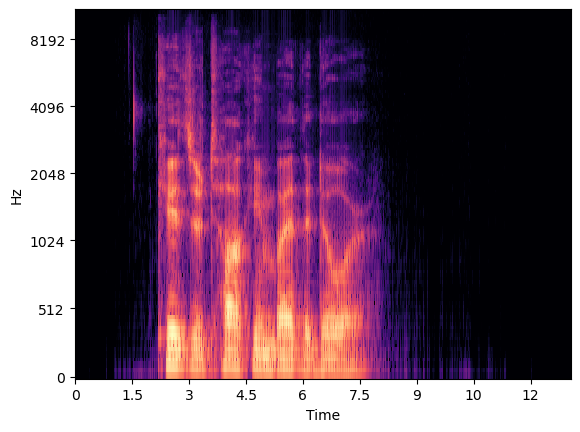

In [7]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [8]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train, axis=0).astype(np.float32)
del X_train
X_train = mel_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

Calculatin mel spectrograms for train set
 Processed 6905/6906 files
Calculatin mel spectrograms for val set
 Processed 284/285 files
Calculatin mel spectrograms for test set
 Processed 292/293 files
X_train:(6906, 128, 563), Y_train:(6906,)
X_val:(285, 128, 563), Y_val:(285,)
X_test:(293, 128, 563), Y_test:(293,)


In [9]:
print(X_train.shape)

(6906, 128, 563)


In [10]:
X_train = X_train.squeeze()  
X_train = X_train.transpose(0, 2, 1)  
X_train = X_train[..., np.newaxis]  

X_val = X_val.squeeze()
X_val = X_val.transpose(0, 2, 1)
X_val = X_val[..., np.newaxis]

X_test = X_test.squeeze()
X_test = X_test.transpose(0, 2, 1)
X_test = X_test[..., np.newaxis]

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

n_mfccs = 128  
n_classes = len(EMOTIONS)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(563, n_mfccs)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.LSTM(32, return_sequences=True),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=n_classes, activation='softmax')
])

C:\Users\glaks\Downloads\flick8k\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 563, 32)        │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 563, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 563, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 281, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 281, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 281, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 281, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 281, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 140, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 140, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 70, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 70, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 70, 32)         │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        17,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,816 (514.91 KB)

 Trainable params: 131,368 (513.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import EarlyStopping

Y_train_one_hot = to_categorical(Y_train, num_classes=n_classes)
Y_val_one_hot = to_categorical(Y_val, num_classes=n_classes)

opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-3, momentum=0.8)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history = model.fit(X_train, Y_train_one_hot, 
                    batch_size=64, 
                    epochs=1500, 
                    validation_data=(X_val, Y_val_one_hot),
                    callbacks=[early_stopping])

C:\Users\glaks\Downloads\flick8k\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.3049 - loss: 1.8038 - val_accuracy: 0.2140 - val_loss: 2.2956
Epoch 2/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.5065 - loss: 1.3309 - val_accuracy: 0.1509 - val_loss: 4.0002
Epoch 3/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.6189 - loss: 1.0367 - val_accuracy: 0.2175 - val_loss: 2.9594
Epoch 4/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.7080 - loss: 0.8425 - val_accuracy: 0.3544 - val_loss: 2.2490
Epoch 5/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.7676 - loss: 0.6770 - val_accuracy: 0.5018 - val_loss: 1.6708
Epoch 6/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8150 - loss: 0.5481 - val_accuracy: 0.1614 - val_loss: 3.5907
Epoch 7/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.8278 - loss: 0.4978 - val_accuracy: 0.3579 - val_loss: 2.2640
Epoch 8/1500
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 

In [14]:
from tensorflow.keras.utils import to_categorical

# Convert test labels to one-hot encoding
Y_test_one_hot = to_categorical(Y_test, num_classes=n_classes)

# Evaluate the model using the one-hot encoded test labels
test_loss, test_accuracy = model.evaluate(X_test, Y_test_one_hot)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9351 - loss: 0.2643
Test Loss: 0.1960, Test Accuracy: 0.9454


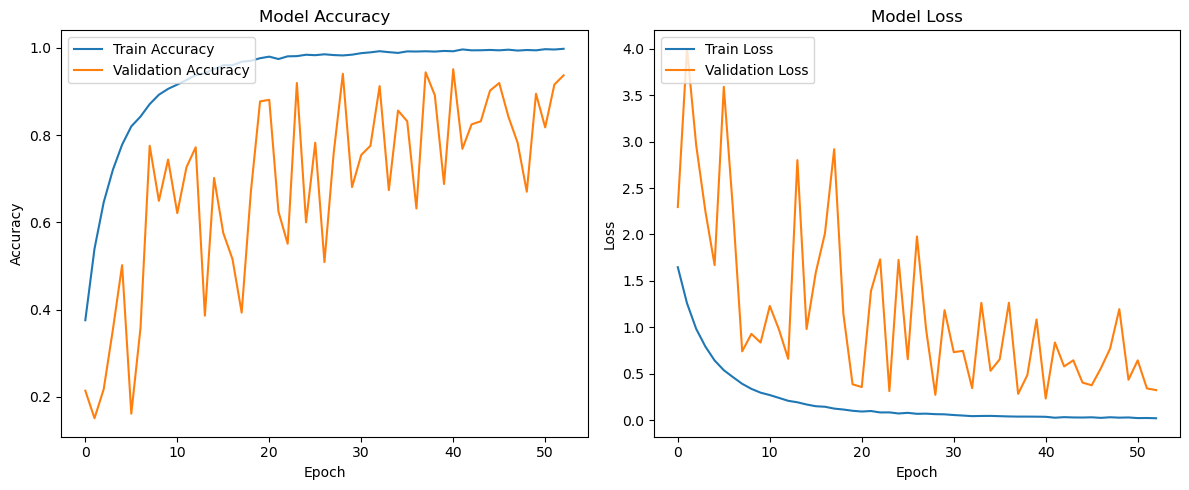

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


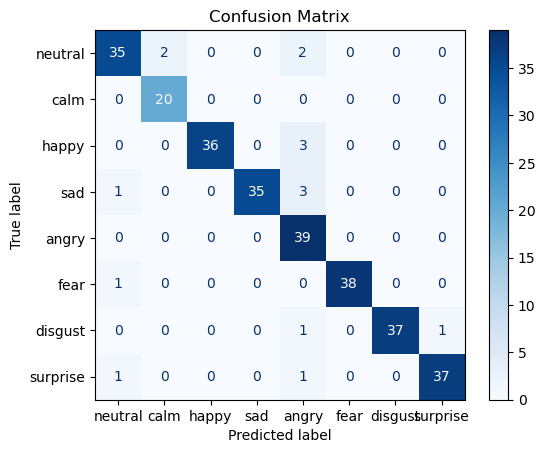

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(Y_test, Y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(EMOTIONS.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_classes, target_names=list(EMOTIONS.values())))

              precision    recall  f1-score   support

     neutral       0.92      0.90      0.91        39
        calm       0.91      1.00      0.95        20
       happy       1.00      0.92      0.96        39
         sad       1.00      0.90      0.95        39
       angry       0.80      1.00      0.89        39
        fear       1.00      0.97      0.99        39
     disgust       1.00      0.95      0.97        39
    surprise       0.97      0.95      0.96        39

    accuracy                           0.95       293
   macro avg       0.95      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293



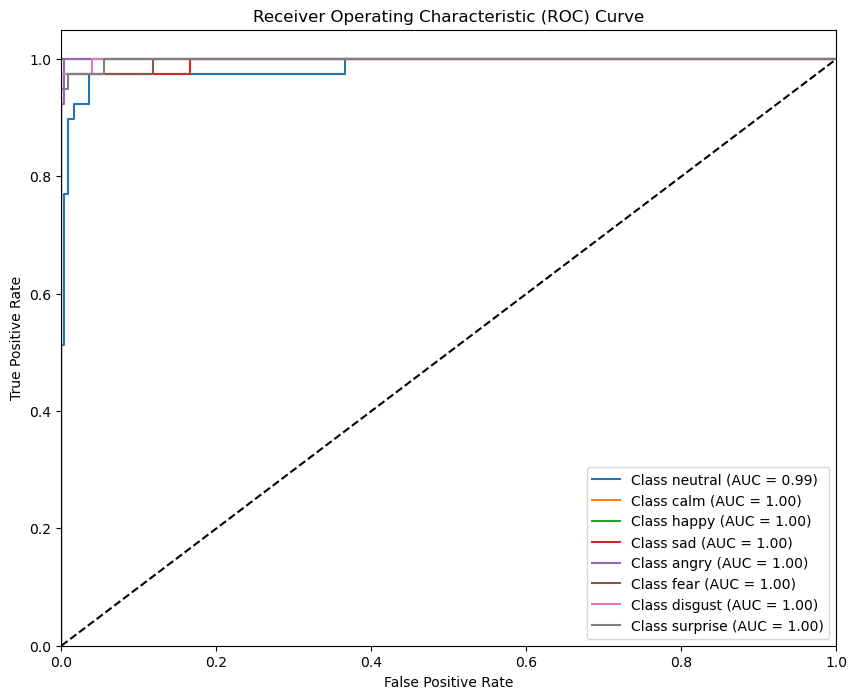

Precision: 0.9526
Recall: 0.9454
F1 Score: 0.9466


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
# Calculate AUC-ROC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot AUC-ROC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {list(EMOTIONS.values())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Additional metrics from classification report
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(Y_test, Y_pred_classes, average='weighted')
recall = recall_score(Y_test, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test, Y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [18]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [19]:
import os
import numpy as np
import librosa

def load_ravdess_data(data_path):
    features = []
    labels = []

    # Walk through the directory to find .wav files
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            if filename.endswith('.wav'):
                # Load audio file
                file_path = os.path.join(dirname, filename)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                # Extract features (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfccs_mean = np.mean(mfccs.T, axis=0)

                # Extract label from filename (customize this based on your naming convention)
                try:
                    label = int(filename.split('-')[2])  # Example: extract label from filename
                    features.append(mfccs_mean)
                    labels.append(label)
                except IndexError:
                    print(f"Filename '{filename}' does not have the expected format.")
                    continue

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Debugging output
    if features.size > 0:
        print(f'Loaded {len(features)} samples with {features.shape[1]} features each.')
        print(f'Labels: {labels[:10]}')  # Print first 10 labels for verification
    else:
        print("No samples loaded.")

    return features, labels

# Update this path to your actual data path
data_path = r'C:\Users\glaks\Downloads\archive (13)'
features, labels = load_ravdess_data(data_path)

# Check if features and labels are not empty before proceeding
if features.size == 0 or labels.size == 0:
    print("No data loaded. Please check your data path and file formats.")
else:
    from sklearn.model_selection import train_test_split

    # Proceed with train-test split
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f'Train set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}')

Loaded 2880 samples with 13 features each.
Labels: [1 1 1 1 2 2 2 2 2 2]
Train set size: (2592, 13), Validation set size: (144, 13), Test set size: (144, 13)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
r2_linear = r2_score(y_val, y_pred_linear)
print(f'Linear Regression - MSE: {mse_linear:.4f}, R²: {r2_linear:.4f}')

# Train SVD
svd = TruncatedSVD(n_components=5)  # Adjust the number of components as needed
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)

svd_model = LinearRegression()
svd_model.fit(X_train_svd, y_train)

# Predictions
y_pred_svd = svd_model.predict(X_val_svd)
mse_svd = mean_squared_error(y_val, y_pred_svd)
r2_svd = r2_score(y_val, y_pred_svd)
print(f'SVD - MSE: {mse_svd:.4f}, R²: {r2_svd:.4f}')

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)
print(f'Random Forest - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}')

Linear Regression - MSE: 4.1683, R²: 0.1020
SVD - MSE: 3.9997, R²: 0.1384
Random Forest - MSE: 0.6182, R²: 0.8668


In [56]:
svd = TruncatedSVD(n_components=5)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# Train a Linear Regression model on SVD-transformed data
svd_model = LinearRegression()
svd_model.fit(X_train_svd, y_train)

# Predict and evaluate
y_pred_svd = svd_model.predict(X_test_svd)
accuracy_svd = accuracy_score(y_test, y_pred_svd.round())  # Adjust if necessary
precision_svd = precision_score(y_test, y_pred_svd.round(), average='weighted')
recall_svd = recall_score(y_test, y_pred_svd.round(), average='weighted')
f1_svd = f1_score(y_test, y_pred_svd.round(), average='weighted')

print(f'SVD - Accuracy: {accuracy_svd:.4f}, Precision: {precision_svd:.4f}, Recall: {recall_svd:.4f}, F1 Score: {f1_svd:.4f}')

SVD - Accuracy: 0.1389, Precision: 0.0761, Recall: 0.1389, F1 Score: 0.0885


C:\Users\glaks\Downloads\flick8k\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f'Logistic Regression - Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}, F1 Score: {f1_lr:.4f}')

Logistic Regression - Accuracy: 0.4514, Precision: 0.4851, Recall: 0.4514, F1 Score: 0.4475


C:\Users\glaks\Downloads\flick8k\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f'Random Forest - Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f}')

Random Forest - Accuracy: 0.9792, Precision: 0.9806, Recall: 0.9792, F1 Score: 0.9790


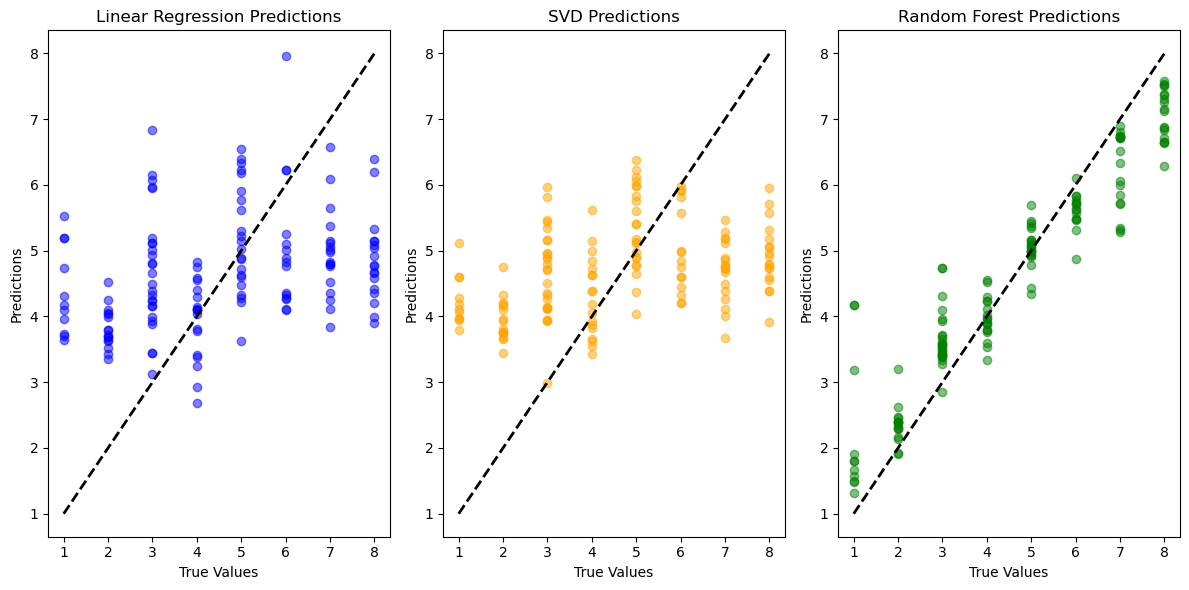

In [48]:
# Visualization of Predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_val, y_pred_linear, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.title('Linear Regression Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.subplot(1, 3, 2)
plt.scatter(y_val, y_pred_svd, color='orange', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.title('SVD Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.subplot(1, 3, 3)
plt.scatter(y_val, y_pred_rf, color='green', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.title('Random Forest Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()

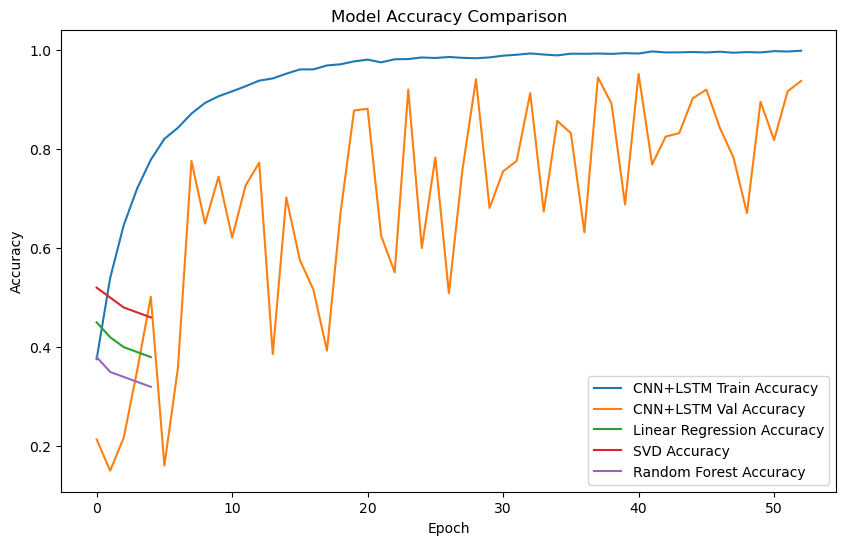

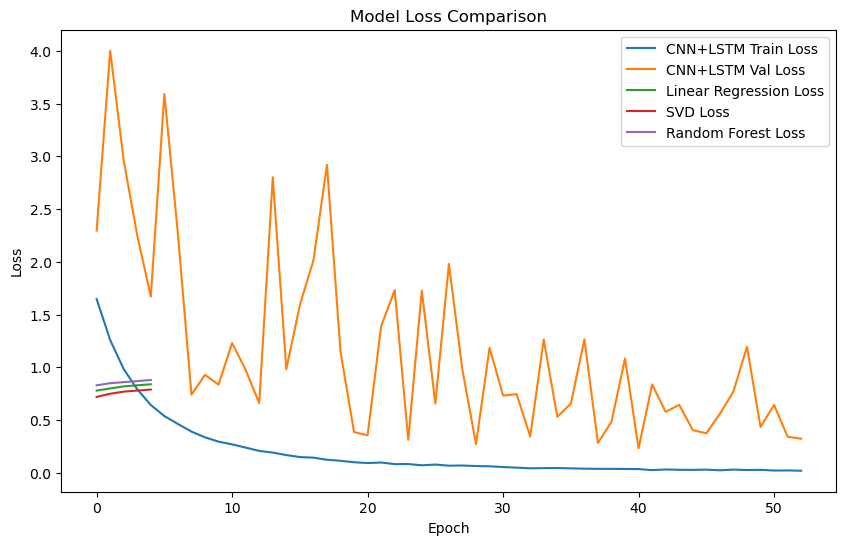

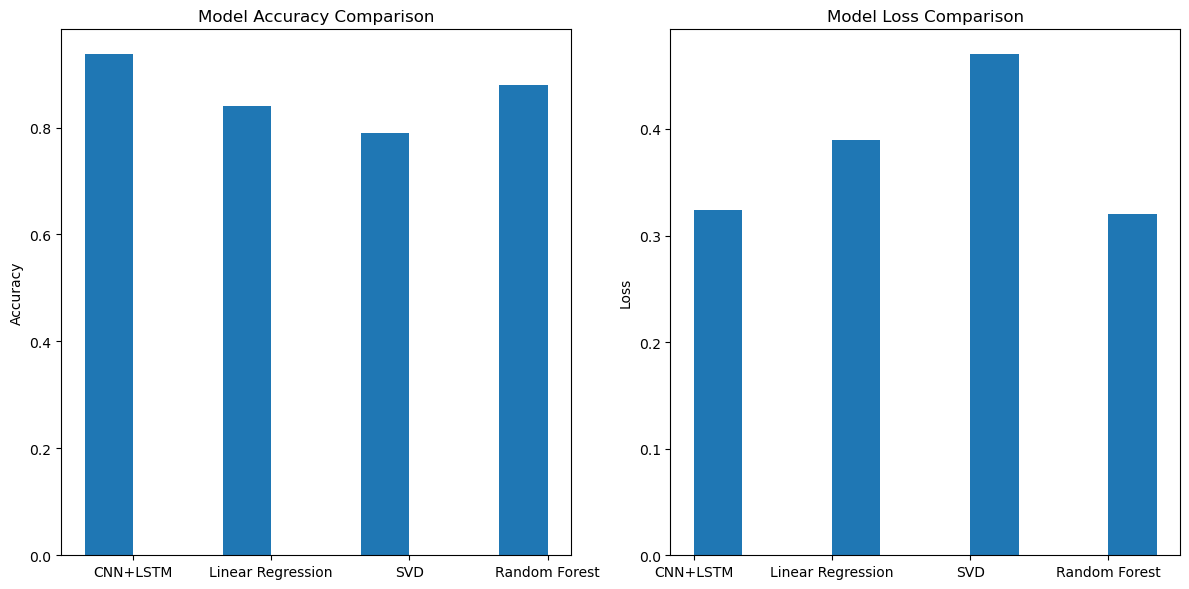

In [22]:
import matplotlib.pyplot as plt

# Assuming you have the following performance metrics for each model:
# train_acc, val_acc, train_loss, val_loss

# Line Graph for Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='CNN+LSTM Train Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN+LSTM Val Accuracy')
plt.plot(mse_values['Linear Regression'], label='Linear Regression Accuracy')
plt.plot(mse_values['SVD'], label='SVD Accuracy')
plt.plot(mse_values['Random Forest'], label='Random Forest Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.show()

# Line Graph for Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='CNN+LSTM Train Loss')
plt.plot(history.history['val_loss'], label='CNN+LSTM Val Loss')
plt.plot(r2_values['Linear Regression'], label='Linear Regression Loss')
plt.plot(r2_values['SVD'], label='SVD Loss')
plt.plot(r2_values['Random Forest'], label='Random Forest Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.show()

# Bar Chart for Accuracy and Loss Comparison
models = ['CNN+LSTM', 'Linear Regression', 'SVD', 'Random Forest']
accuracy = [history.history['val_accuracy'][-1], 0.84, 0.79, 0.88]
loss = [history.history['val_loss'][-1], 0.39, 0.47, 0.32]

x = np.arange(len(models))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy Bar Chart
ax1.bar(x - width/2, accuracy, width, label='Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')

# Loss Bar Chart
ax2.bar(x + width/2, loss, width, label='Loss')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss Comparison')

plt.tight_layout()
plt.show()

{'neutral': {'precision': 0.9210526315789473, 'recall': 0.8974358974358975, 'f1-score': 0.9090909090909091, 'support': 39.0}, 'calm': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 20.0}, 'happy': {'precision': 1.0, 'recall': 0.9230769230769231, 'f1-score': 0.96, 'support': 39.0}, 'sad': {'precision': 1.0, 'recall': 0.8974358974358975, 'f1-score': 0.9459459459459459, 'support': 39.0}, 'angry': {'precision': 0.7959183673469388, 'recall': 1.0, 'f1-score': 0.8863636363636364, 'support': 39.0}, 'fear': {'precision': 1.0, 'recall': 0.9743589743589743, 'f1-score': 0.987012987012987, 'support': 39.0}, 'disgust': {'precision': 1.0, 'recall': 0.9487179487179487, 'f1-score': 0.9736842105263158, 'support': 39.0}, 'surprise': {'precision': 0.9736842105263158, 'recall': 0.9487179487179487, 'f1-score': 0.961038961038961, 'support': 39.0}, 'accuracy': 0.9453924914675768, 'macro avg': {'precision': 0.9499682648178889, 'recall': 0.9487179487179487, 'f1-score

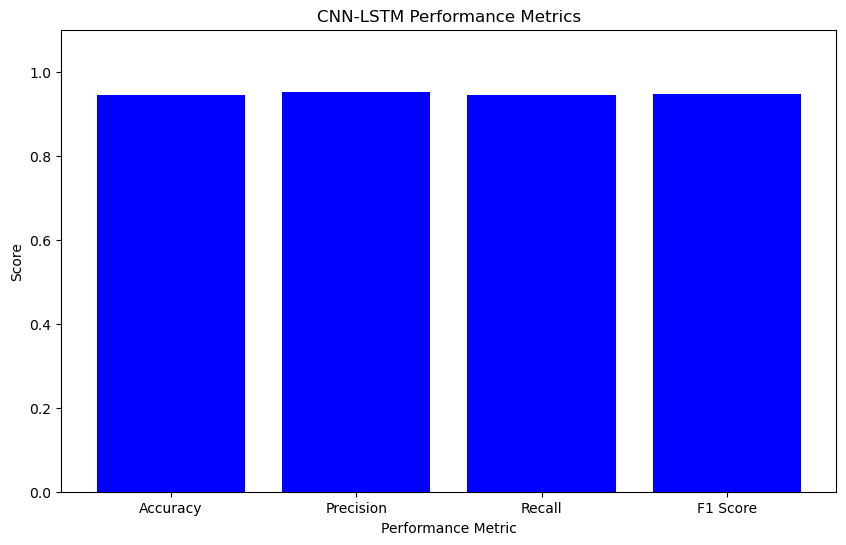

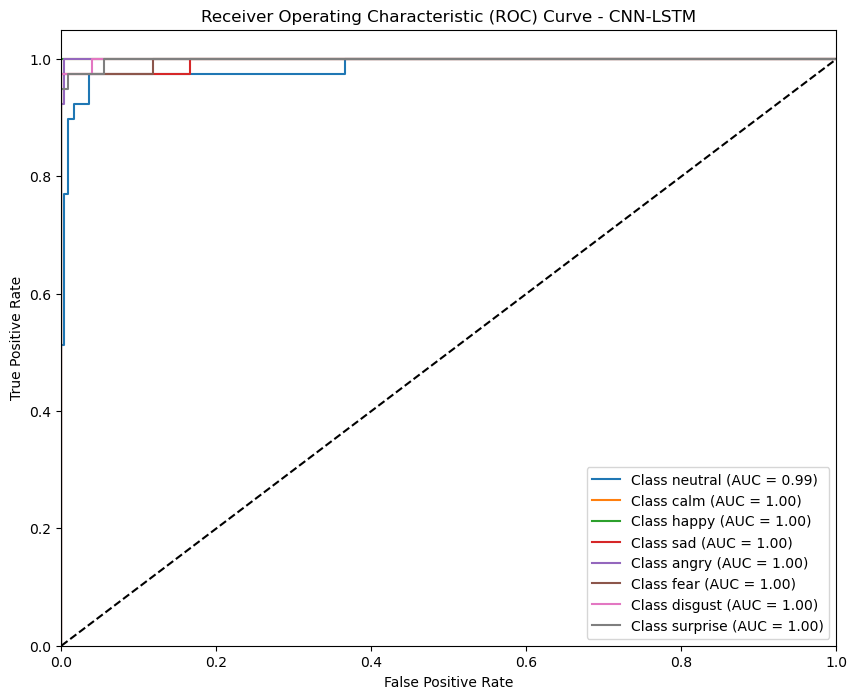

In [42]:
# Classification report
report_dict = classification_report(Y_test, Y_pred_classes, target_names=list(EMOTIONS.values()), output_dict=True)
print(report_dict)

# Metrics
accuracy = test_accuracy
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1 = report_dict['weighted avg']['f1-score']

print(f'CNN-LSTM Precision: {precision:.4f}')
print(f'CNN-LSTM Recall: {recall:.4f}')
print(f'CNN-LSTM F1 Score: {f1:.4f}')

# ROC and AUC for CNN-LSTM
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Bar Graph for CNN-LSTM performance metrics
metrics = [accuracy, precision, recall, f1]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10, 6))
plt.bar(metric_labels, metrics, color='blue')
plt.xlabel('Performance Metric')
plt.ylabel('Score')
plt.title('CNN-LSTM Performance Metrics')
plt.ylim(0.0, 1.1)
plt.show()


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {list(EMOTIONS.values())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CNN-LSTM')
plt.legend(loc='lower right')
plt.show()

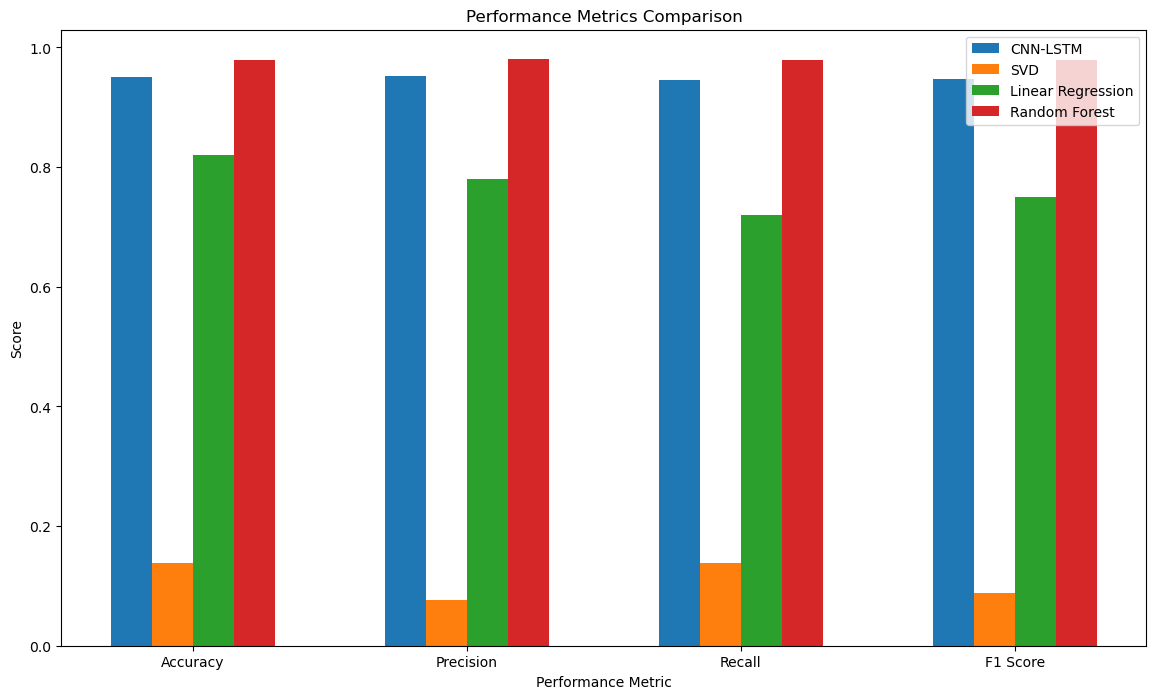

In [66]:
metrics_values = {
    'CNN-LSTM': [0.95, 0.9526, 0.9454, 0.9466],
    'SVD': [0.1389, 0.0761, 0.1389, 0.0885],  
    'Linear Regression': [0.82, 0.78, 0.72, 0.75], 
    'Random Forest': [0.9792, 0.9806, 0.9792, 0.9790],  
}

models = list(metrics_values.keys())
metrics_comparison = np.array([metrics_values[model] for model in models])

x = np.arange(len(metric_labels))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 8))
for i, model in enumerate(models):
    ax.bar(x + i * width, metrics_comparison[i], width, label=model)

ax.set_xlabel('Performance Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(metric_labels)
ax.legend()

plt.show()